# 中國信託作業
##### 資料來源: https://www.kaggle.com/c/ctbcsec-interview/overview

<font color=#8B4513 size=600 face="標楷體"> 格式調整</font>

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("D:\class\Kaggle_data\CTBCSEC\Train_X.csv",encoding = "cp950").sort_values("日期")#依照日期排序,大五不能開所以改cp90

In [4]:
#取出有交易的日期
stock_date_list=list(df["日期"].drop_duplicates( keep='first', inplace=False))

In [6]:
#因為檔案太大電腦跑不動,且擔心成交量過低之股票無法及時反映真實價格,因此取20140127成交金額超過2億的
stock_20140127 = df[0:0]
for i in range(5000):
    if str(list(df.loc[i:i]["日期"])[0])==str("20140127"):
        stock_20140127 = stock_20140127.append(df.loc[i:i],ignore_index=True) 
# stock_list=list(df["股票代號"].drop_duplicates( keep='first', inplace=False).sort_values("成交金額.千."))

In [8]:
#因為檔案太大電腦跑不動,因此取20140127成交金額超過2億的
stock_volover200m_df=df[0:0]
for i in range(1688):
    if str(list(stock_20140127.loc[i:i]["股票代號"])[0])<str(9999):                  #只找現股(股號<9999)
        if float(list(stock_20140127.loc[i:i]["成交金額.千."])[0])>float(200000):    #成交量
            stock_volover200m_df = stock_volover200m_df.append(stock_20140127.loc[i:i],ignore_index=True) 

In [9]:
#選出的股票代碼清單
stock_volover200m_list = list(stock_volover200m_df["股票代號"])

In [10]:
#怕當機,分段做
test = stock_volover200m_list[110:120]
test

['6505', '8076', '8121', '8299', '8406', '9904', '9914', '9921', '9945']

In [528]:
#拆成各股,調整日期並存檔
names = locals()
for i in test:
    names['stock_%s' % i] = df[0:0]
    for a in range(len(df)):
         if str(list(df.loc[a:a]["股票代號"])[0])==str(i):
            names['stock_%s' % i] = names['stock_%s' % i].append(df.loc[a:a],ignore_index=True)
    names['stock_%s' % i]=names['stock_%s' % i].sort_values("日期")                                #按照日期做排序
    names['stock_%s' % i] = names['stock_%s' % i].rename(columns={'Unnamed: 0':'Unnamed: 0_%s'% i,
 '日期':'日期_%s'% i,
 '股票代號':'股票代號_%s'% i,
 '股票名稱':'股票名稱_%s'% i,
 '開盤價':'開盤價_%s'% i,
 '最高價':'最高價_%s'% i,
 '最低價':'最低價_%s'% i,
 '收盤價':'收盤價_%s'% i,
 '漲跌':'漲跌_%s'% i,
 '漲幅...':'漲幅..._%s'% i,
 '振幅...':'振幅..._%s'% i,
 '成交量':'成交量_%s'% i,
 '成交筆數':'成交筆數_%s'% i,
 '成交金額.千.':'成交金額.千._%s'% i,
 '均張':'均張_%s'% i,
 '成交量變動...':'成交量變動..._%s'% i,
 '均張變動...':'均張變動..._%s'% i,
 '股本.百萬.':'股本.百萬._%s'% i,
 '總市值.億.': '總市值.億._%s'% i,
 '市值比重...':'市值比重..._%s'% i,
 '本益比':'本益比_%s'% i,
 '股價淨值比':'股價淨值比_%s'% i,
 '本益比.近四季.':'本益比.近四季._%s'% i,
 '週轉率...':'週轉率..._%s'% i,
 '成交值比重...':'成交值比重..._%s'% i,
 '漲跌停':'漲跌停_%s'% i,
 '均價':'均價_%s'% i,
 '成交量.股.':'成交量.股._%s'% i,
 'RTIME':'RTIME_%s'%i})
    names['stock_%s' % i].to_csv(r"D:\class\Kaggle_data\CTBCSEC\拆開\stock_%s.csv"% i,encoding = "cp950")

In [117]:
#開黨,依照經驗,主觀選取可能較有用的變數,全部merage在一起
stock_merge = pd.read_csv("D:\class\Kaggle_data\CTBCSEC\拆開\stock_0050.csv",encoding = "cp950").rename(columns={"日期_0050":"日期"}).loc[:,["日期"]]
names = locals()
for i in stock_volover200m_list:
    names['stock_%s' % i] = pd.read_csv("D:\class\Kaggle_data\CTBCSEC\拆開\stock_%s.csv"% i,encoding = "cp950")
    names['stock_%s' % i] = names['stock_%s' % i].rename(columns={'日期_%s'% i:'日期'})   #日期改成一樣做merage
    stock_merge = pd.merge(stock_merge, names['stock_%s' % i].loc[:,["日期","收盤價_%s"%i,"漲幅..._%s"%i,"振幅..._%s"%i,"成交金額.千._%s"%i,"均張_%s"%i,"成交量變動..._%s"%i,
                            "週轉率..._%s"%i]], how='left', on='日期')
print(stock_merge.shape)      #看維度
#    .loc[:,["日期","收盤價_%s"%i,"漲幅..._%s"%i,"振幅..._%s"%i,"成交金額.千._%s"%i,"均張_%s"%i,"成交量變動..._%s"%i,
#                             "週轉率..._%s"%i]]

(237, 834)


<font color=#8B4513 size=100 face="標楷體"> 資料預處理 </font>

In [214]:
#向量自回歸抓領先變數
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from statsmodels.tsa.base.datetools import dates_from_str
import math
from statsmodels.tsa.vector_ar.hypothesis_test_results import \
    CausalityTestResults, NormalityTestResults, WhitenessTestResults
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy as sp

In [339]:
#開Train_Y,mera
Train_Y = pd.read_csv(r'D:\class\Kaggle_data\CTBCSEC\Train_Y.csv',encoding = "cp950")

In [19]:
i=2330
var_list = stock_2330.loc[:,["日期","收盤價_%s"%i,"漲幅..._%s"%i,"振幅..._%s"%i,"成交金額.千._%s"%i,"均張_%s"%i,"成交量變動..._%s"%i,
                            "週轉率..._%s"%i]]
var_list

,日期,收盤價_2330,漲幅..._2330,振幅..._2330,成交金額.千._2330,均張_2330,成交量變動..._2330,週轉率..._2330
0,20140102,104.5,-0.95,1.90,1578861.0,3.7,-38.19,0.06
1,20140103,102.5,-1.91,0.96,4220063.0,4.8,171.99,0.16
2,20140106,102.5,0.00,0.98,2432746.0,4.9,-42.35,0.09
3,20140107,102.0,-0.49,0.98,1907188.0,3.4,-20.76,0.07
4,20140108,104.0,1.96,1.96,3209563.0,4.2,64.51,0.12
5,20140109,101.0,-2.88,2.40,6522627.0,3.2,107.61,0.25
6,20140110,102.0,0.99,0.99,3703541.0,4.8,-43.49,0.14
7,20140113,103.0,0.98,0.98,2273074.0,3.5,-39.16,0.09
8,20140114,103.5,0.49,1.46,2237630.0,4.1,-1.64,0.08
9,20140115,105.0,1.45,1.93,5722579.0,3.5,150.75,0.21


In [807]:
var_list= pd.merge(var_list, Train_Y, how='left', on='日期')

In [21]:
#把labelY併進去X
stock_merge_XY = pd.merge(stock_merge, Train_Y, how='left', on='日期')
stock_merge_XY.astype(float)
stock_merge_XY.dropna(axis=1, how='any', thresh=None, subset=None, inplace=False)

,日期,收盤價_0050,漲幅..._0050,振幅..._0050,成交金額.千._0050,均張_0050,成交量變動..._0050,週轉率..._0050,收盤價_1101,漲幅..._1101,...,成交量變動..._9921,週轉率..._9921,收盤價_9945,漲幅..._9945,振幅..._9945,成交金額.千._9945,均張_9945,成交量變動..._9945,週轉率..._9945,Target_Y
0,20140102,58.55,-0.26,0.68,629995.0,4.6,-12.19,0.77,45.40,-1.84,...,5.86,0.06,57.90,0.17,0.87,129958.0,1.7,-49.22,0.19,8612.11
1,20140103,57.85,-1.20,1.28,840196.0,4.0,34.82,1.04,44.55,-1.87,...,15.74,0.07,57.70,-0.35,0.86,131524.0,1.8,1.56,0.19,8596.00
2,20140106,57.70,-0.26,0.69,857371.0,4.1,2.49,1.07,43.60,-2.13,...,8.82,0.08,55.60,-3.64,5.03,426317.0,1.9,231.84,0.64,8621.56
3,20140107,57.70,0.00,0.35,758132.0,5.1,-11.71,0.95,44.15,1.26,...,13.51,0.09,55.30,-0.54,2.34,371119.0,1.8,-11.33,0.56,8599.90
4,20140108,57.80,0.17,0.43,439845.0,3.8,-42.07,0.55,43.90,-0.57,...,39.58,0.13,55.90,1.08,2.35,354879.0,1.7,-5.64,0.53,8625.30
5,20140109,57.55,-0.43,0.69,493178.0,3.7,12.70,0.62,42.90,-2.28,...,33.48,0.17,55.50,-0.72,1.97,338903.0,1.8,-3.34,0.51,8595.10
6,20140110,57.55,0.00,0.26,272993.0,4.6,-44.69,0.34,43.80,2.10,...,-27.00,0.12,54.40,-1.98,3.06,536029.0,1.7,60.33,0.83,8598.31
7,20140113,57.90,0.61,0.70,358200.0,3.7,30.33,0.45,43.80,0.00,...,42.01,0.18,53.60,-1.47,3.13,468268.0,1.9,-11.62,0.73,8462.57
8,20140114,57.80,-0.17,0.43,246832.0,2.4,-30.80,0.31,44.10,0.68,...,-22.50,0.13,53.90,0.56,1.68,266065.0,1.6,-42.93,0.41,8264.48
9,20140115,58.40,1.04,0.87,680334.0,3.1,173.04,0.84,44.75,1.47,...,96.62,0.27,54.10,0.37,0.93,158003.0,1.5,-41.04,0.25,8311.01


In [296]:
#做向量自回歸後做grander,若某因子顯著對Target_Y有領先性,則納入此變數至Significant_factor中
#因為維度裡面有包含變動率,因此就不做差分與ln了
#顯著水準=0.1,根據經驗,滯後一期效果較好
Significant_factor = pd.read_csv("D:\class\Kaggle_data\CTBCSEC\拆開\stock_0050.csv",encoding = "cp950").rename(columns={"日期_0050":"日期"}).loc[:,["日期"]]
for i in stock_volover200m_list:
    try:
        names['stock_%s' % i] = pd.read_csv("D:\class\Kaggle_data\CTBCSEC\拆開\stock_%s.csv"% i,encoding = "cp950")
        var_list = names['stock_%s'%i].loc[:,["日期_%s"%i,"收盤價_%s"%i,"漲幅..._%s"%i,"振幅..._%s"%i,"成交金額.千._%s"%i,"均張_%s"%i,"成交量變動..._%s"%i,
                                    "週轉率..._%s"%i]]
        var_list = var_list.rename(columns={'日期_%s'% i:'日期'})
        var_list_Y= pd.merge(var_list, Train_Y, how='left', on='日期')
        model = VAR(var_list_Y)
        results = model.fit(1)   
        for a in range(1,8):
            p_value = results.test_causality("Target_Y",causing=var_list_Y.iloc[:,[a]], kind='f', signif=0.1).pvalue
            if p_value<0.1:
                Significant_factor = pd.merge(Significant_factor, var_list_Y.iloc[:,[0,a]], how='left', on='日期')
    except:
        pass
print("顯著的因子有",Significant_factor.shape[1],"個")      
           


顯著的因子有 94 個


In [297]:
#貢線性,去除vif>100的
cc = sp.corrcoef(Significant_factor, rowvar=False)
VIF = np.linalg.inv(cc)
VIF_list=VIF.diagonal()
VIF_100 = np.where(VIF_list>100)    #找VIF>100的列
VIF_100 = VIF_100[0][1:]            #留日期
Significant_factor.drop(Significant_factor.columns[VIF_100], axis=1,inplace=True)
Significant_factor.shape
Significant_factor.to_csv(r"D:\class\Kaggle_data\CTBCSEC\拆開\Significant_factor.csv",encoding="cp950")

In [375]:
#因為要用至當日以前之數據預測明日,應把train_X滯後一期,等價Target_Y提前一期
Adjust_Train_Y = Train_Y[["日期"]]
shift = Train_Y[['Target_Y']].shift(-1) 
shift.columns = ['Target_Y'] 
Adjust_Train_Y = pd.concat([Adjust_Train_Y, shift], axis=1) 

<font color=#8B4513 size=600 face="標楷體"> 開始建模</font>

<font color=#ff3333 size=5 face="標楷體"> LSTM</font>

In [308]:
import numpy as np
import matplotlib.pyplot as plt  
import pandas as pd
import tensorflow as tf
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm

In [306]:
Significant_factor = pd.read_csv(r"D:\class\Kaggle_data\CTBCSEC\拆開\Significant_factor.csv",encoding="cp950")
Significant_factor

,Unnamed: 0,日期,振幅..._1216,成交量變動..._1216,收盤價_1326,收盤價_1402,收盤價_1504,振幅..._1504,收盤價_1590,成交量變動..._1722,...,週轉率..._4966,收盤價_5347,收盤價_5356,收盤價_5483,成交量變動..._5871,收盤價_6147,振幅..._6176,收盤價_6271,收盤價_6505,振幅..._9904
0,0,20140102,1.30,-26.54,83.1,33.95,34.15,1.46,250.0,23.90,...,5.90,35.80,56.4,52.40,-28.95,46.50,1.38,139.5,81.1,3.59
1,1,20140103,1.48,71.33,82.7,33.50,33.85,1.32,247.0,-5.98,...,4.64,35.90,58.0,56.00,89.10,46.15,1.81,140.0,80.0,2.41
2,2,20140106,0.93,-35.35,82.7,33.10,33.55,2.36,240.5,59.45,...,4.75,35.40,57.6,58.60,2.89,42.95,1.80,143.5,81.0,6.09
3,3,20140107,0.75,8.01,81.9,33.10,33.10,1.79,247.0,-47.60,...,5.39,36.00,57.8,58.60,-46.49,43.50,3.64,143.5,81.1,3.45
4,4,20140108,0.94,51.29,81.7,33.60,33.00,1.66,247.0,73.38,...,8.52,36.35,57.8,61.60,35.39,44.15,5.73,145.0,81.9,2.91
5,5,20140109,1.69,63.91,82.2,33.30,33.00,2.27,247.0,32.46,...,3.01,35.40,56.7,59.50,13.53,45.60,5.79,148.0,82.6,4.47
6,6,20140110,0.76,-46.41,81.3,33.40,34.30,3.03,246.0,-38.55,...,3.05,34.25,56.8,60.00,-37.13,45.80,6.53,142.0,81.0,1.45
7,7,20140113,0.96,-11.69,81.6,33.80,33.40,3.94,245.5,-5.87,...,2.35,34.35,56.9,57.90,244.31,44.65,7.63,144.5,83.1,6.41
8,8,20140114,1.34,36.45,80.8,33.75,33.90,2.54,246.0,-32.40,...,1.90,33.80,56.7,56.50,-57.42,45.10,2.80,140.5,82.0,3.18
9,9,20140115,0.96,57.38,80.8,33.20,33.75,2.21,263.0,110.40,...,3.11,33.95,56.6,56.70,144.59,46.05,3.92,146.0,81.1,1.68


<font color=#ff3333 size=5 face="標楷體"> 機器學習 </font>

In [726]:
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, auc
import pandas as pd
import numpy as np
from sklearn.svm import SVC,SVR
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error,mean_absolute_error
from sklearn.svm import LinearSVR
from sklearn.datasets import make_regression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import NuSVR
from sklearn.tree import DecisionTreeRegressor

In [818]:
#因有將train_Y做提前一期,因此刪除最後一row
#標準化

Significant_factor = pd.read_csv(r"D:\class\Kaggle_data\CTBCSEC\拆開\Significant_factor.csv",encoding="cp950")
scale = StandardScaler() 
Significant_factor = pd.DataFrame(scale.fit_transform(Significant_factor),columns=Significant_factor.keys())
train_data, test_data, train_targets, test_targets = train_test_split(Significant_factor.iloc[0:236, 2:] , Adjust_Train_Y.iloc[0:236,1:] , test_size=0.3,shuffle=False)

"""
不標準化
Significant_factor = pd.read_csv(r"D:\class\Kaggle_data\CTBCSEC\拆開\Significant_factor.csv",encoding="cp950")
# scale = StandardScaler() 
# Significant_factor = pd.DataFrame(scale.fit_transform(Significant_factor),columns=Significant_factor.keys())
train_data, test_data, train_targets, test_targets = train_test_split(Significant_factor.iloc[0:236, 2:] , Adjust_Train_Y.iloc[0:236,1:] , test_size=0.3,shuffle=False)


#正規化
Significant_factor = pd.read_csv(r"D:\class\Kaggle_data\CTBCSEC\拆開\Significant_factor.csv",encoding="cp950")
scale = MinMaxScaler() 
Significant_factor = pd.DataFrame(scale.fit_transform(Significant_factor),columns=Significant_factor.keys())
train_data, test_data, train_targets, test_targets = train_test_split(Significant_factor.iloc[0:236, 2:] , Adjust_Train_Y.iloc[0:236,1:] , test_size=0.3,shuffle=False)

"""

In [875]:
"""
測試每個模型的準確度
並嘗試用共識算法試著取得更高的準確度
與經驗不同的是,共識算法在這邊表現較差
與經驗相同的是,單獨模型則以xgboost穩居第一
樣本太少了,怕overfit暫時不調參數

"""
model_xgb = xgb.XGBRegressor()
model_RandomForestRegressor = RandomForestRegressor()
model_LinearSVR = LinearSVR()#不好
model_SVR = SVR()#不好
model_AdaBoostRegressor = AdaBoostRegressor(random_state=0, n_estimators=100)
model_BaggingRegressor = BaggingRegressor(base_estimator=SVR(),n_estimators=10, random_state=0)#不好
model_KernelRidge = KernelRidge()   #不能標準化與正規化,why?
model_KNeighborsRegressor= KNeighborsRegressor()#一定要標準化,why?
model_NuSVR = NuSVR()#不好
model_DecisionTreeRegressor = DecisionTreeRegressor()
Vote = VotingRegressor([("model_xgb",model_xgb),
                        ("model_RandomForestRegressor",model_RandomForestRegressor),
                        ("model_AdaBoostRegressor",model_AdaBoostRegressor),
#                        ("model_KNeighborsRegressor",model_KNeighborsRegressor),
                       ("model_DecisionTreeRegressor",model_DecisionTreeRegressor)])
model_list = [model_xgb,model_RandomForestRegressor,model_LinearSVR,model_AdaBoostRegressor,model_KNeighborsRegressor,
              model_DecisionTreeRegressor]

In [876]:
for model in model_list:
    model.fit(train_data, train_targets)
    y_pred = model.predict(test_data)
    mae=mean_absolute_error(test_targets, y_pred)
    print(model,"平均誤差點數為",mae)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None) 平均誤差點數為 231.35771236795782


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False) 平均誤差點數為 347.1190281690145


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0) 平均誤差點數為 7383.27620552686


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=100, random_state=0) 平均誤差點數為 323.68311362513714
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform') 平均誤差點數為 279.5467042253521
DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best') 平均誤差點數為 368.8163380281691


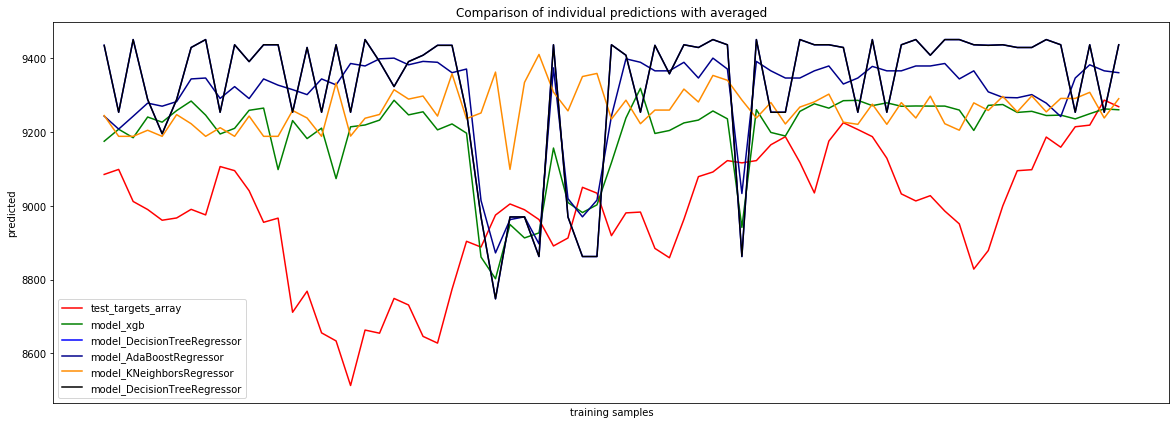

In [879]:
#視覺化,紅色為標準答案
test_targets_array=test_targets.values
plt.figure(figsize=(20, 7)) 
xt = test_data[:]
plt.plot(test_targets_array, 'r', label='test_targets_array')
plt.plot(model_xgb.predict(xt), 'g', label='model_xgb')
plt.plot(model_DecisionTreeRegressor.predict(xt), 'b', label='model_DecisionTreeRegressor')
plt.plot(model_AdaBoostRegressor.predict(xt), '#00008B', label='model_AdaBoostRegressor')
plt.plot(model_KNeighborsRegressor.predict(xt), '#FF8C00', label='model_KNeighborsRegressor')
plt.plot(model_DecisionTreeRegressor.predict(xt), '#000000', label='model_DecisionTreeRegressor')

plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc="best")
plt.title('Comparison of individual predictions with averaged')
plt.show()

In [880]:
"""
機器學習結論
1.在日K中並未見到領先性,但以前我自己做分K時有領先
2.雖然預測不貼,但似乎可發現若預測價格與實際價格落差很大的話,實際價格似乎會往預測價格收斂
3.集成學習似乎效果不彰,與先前經驗違背
4.可能可以試著定義型態並帶入維度中
"""

'\n機器學習結論\n1.在日K中並未見到領先性,但以前我自己做分K時有領先\n2.雖然預測不貼,但似乎可發現若預測價格與實際價格落差很大的話,實際價格似乎會往預測價格收斂\n3.集成學習似乎效果不彰,與先前經驗違背\n4.可能可以試著定義型態並帶入維度中\n'

In [172]:
 #來源https://www.statsmodels.org/dev/_modules/statsmodels/tsa/vector_ar/var_model.html#VARResults.test_causality
def test_causality(self, caused, causing=None, kind='f', signif=0.05):

        """
        Test Granger causality

        Parameters
        ----------
        caused : int or str or sequence of int or str
            If int or str, test whether the variable specified via this index
            (int) or name (str) is Granger-caused by the variable(s) specified
            by `causing`.
            If a sequence of int or str, test whether the corresponding
            variables are Granger-caused by the variable(s) specified
            by `causing`.
        causing : int or str or sequence of int or str or None, default: None
            If int or str, test whether the variable specified via this index
            (int) or name (str) is Granger-causing the variable(s) specified by
            `caused`.
            If a sequence of int or str, test whether the corresponding
            variables are Granger-causing the variable(s) specified by
            `caused`.
            If None, `causing` is assumed to be the complement of `caused`.
        kind : {'f', 'wald'}
            Perform F-test or Wald (chi-sq) test
        signif : float, default 5%
            Significance level for computing critical values for test,
            defaulting to standard 0.05 level

        Notes
        -----
        Null hypothesis is that there is no Granger-causality for the indicated
        variables. The degrees of freedom in the F-test are based on the
        number of variables in the VAR system, that is, degrees of freedom
        are equal to the number of equations in the VAR times degree of freedom
        of a single equation.

        Test for Granger-causality as described in chapter 7.6.3 of [1]_.
        Test H0: "`causing` does not Granger-cause the remaining variables of
        the system" against  H1: "`causing` is Granger-causal for the
        remaining variables".

        Returns
        -------
        results : CausalityTestResults

        References
        ----------
        .. [1] Lütkepohl, H. 2005. *New Introduction to Multiple Time Series Analysis*. Springer.
        """
        if not (0 < signif < 1):
            raise ValueError("signif has to be between 0 and 1")

        allowed_types = (str, int)

        if isinstance(caused, allowed_types):
            caused = [caused]
        if not all(isinstance(c, allowed_types) for c in caused):
            raise TypeError("caused has to be of type string or int (or a "
                            "sequence of these types).")
        caused = [self.names[c] if type(c) == int else c for c in caused]
        caused_ind = [util.get_index(self.names, c) for c in caused]

        if causing is not None:

            if isinstance(causing, allowed_types):
                causing = [causing]
            if not all(isinstance(c, allowed_types) for c in causing):
                raise TypeError("causing has to be of type string or int (or "
                                "a sequence of these types) or None.")
            causing = [self.names[c] if type(c) == int else c for c in causing]
            causing_ind = [util.get_index(self.names, c) for c in causing]

        if causing is None:
            causing_ind = [i for i in range(self.neqs) if i not in caused_ind]
            causing = [self.names[c] for c in caused_ind]

        k, p = self.neqs, self.k_ar
        if p == 0:
            err = "Cannot test Granger Causality in a model with 0 lags."
            raise RuntimeError(err)

        # number of restrictions
        num_restr = len(causing) * len(caused) * p
        num_det_terms = self.k_exog

        # Make restriction matrix
        C = np.zeros((num_restr, k * num_det_terms + k**2 * p), dtype=float)
        cols_det = k * num_det_terms
        row = 0
        for j in range(p):
            for ing_ind in causing_ind:
                for ed_ind in caused_ind:
                    C[row, cols_det + ed_ind + k * ing_ind + k**2 * j] = 1
                    row += 1

        # Lütkepohl 3.6.5
        Cb = np.dot(C, vec(self.params.T))
        middle = np.linalg.inv(C @ self.cov_params() @ C.T)

        # wald statistic
        lam_wald = statistic = Cb @ middle @ Cb

        if kind.lower() == 'wald':
            df = num_restr
            dist = stats.chi2(df)
        elif kind.lower() == 'f':
            statistic = lam_wald / num_restr
            df = (num_restr, k * self.df_resid)
            dist = stats.f(*df)
        else:
            raise ValueError('kind %s not recognized' % kind)

        pvalue = dist.sf(statistic)
        crit_value = dist.ppf(1 - signif)

        return CausalityTestResults(causing, caused, statistic,
                                    crit_value, pvalue, df, signif,
                                    test="granger", method=kind)

